In [1]:
from gensim.models.poincare import PoincareModel
from sklearn.decomposition import PCA
import xml.etree.ElementTree as ET
import re
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import numpy as np

C:\Users\bwesterber\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Helping functions used to parse the XML drug database

In [2]:
def build_drug_dataframe(root):
    names = []
    atc_level_five = []  
    for drug in list(root):
        atc_codes = drug.find('{http://www.drugbank.ca}atc-codes')
        name = drug.find('{http://www.drugbank.ca}name').text
        # hold ATC values collected for each drug
        for elem in atc_codes.iter():
            try:
                atc_five = re.search('[A-Z][0-9]{2}[A-Z]{2}[0-9]{2}', elem.attrib['code'])
                if atc_five != None:
                    atc_level_five.append(atc_five.group(0))
                    names.append(name)
            except KeyError:
                pass
    return pd.DataFrame({'Name':names, 'ATC5':atc_level_five})

def build_transitive_closure(df):
    edges = []
    drug_names = df['Name'].unique()
    # iterate through drugs
    for drug in drug_names:
        codes = df[df['Name'] == drug]
        # build root to branch verticies for each ACT (asymmetric)
        for atc in codes['ATC5']:
            edges.append(('DRUG', atc[0]))
            edges.append((atc[0], atc[0:3]))
            edges.append((atc[0:3], atc[0:4]))
            edges.append((atc[0:4], atc[0:5]))
            edges.append((atc[0:5], atc[0:]))
        # if a drug has multiple ATC codes link them together 
        if len(codes) > 1:
            edges + list(itertools.permutations(codes['ATC5'], 2))
    return edges

Collect ATC drug codes and build graph

In [4]:
# TODO: Pull data from S3 instead of local path
path = r'C:\Users\bwesterber\Desktop\Capstone\full database.xml'
tree = ET.parse(path)
root = tree.getroot()

# build dataframe with drug name and ATC codes
df = build_drug_dataframe(root)
# create all edge/vertex pairs
edges = build_transitive_closure(df)

In [5]:
# fit poincare embedding
        
model = PoincareModel(edges, burn_in = 10, negative = 10, alpha = 1)
model.train(epochs = 50)

In [11]:
# apply embeddings

drug_names = list(df['ATC5'].unique())
vectors = []
drugs = []

for drug in drug_names:
    vectors.append(model.kv.word_vec(drug))
    drugs.append(drug)

df_embedded = pd.DataFrame(vectors)

Text(0, 0.5, 'PC2 (9.0 %)')

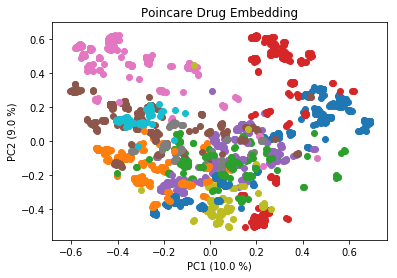

In [15]:
# visualize embedding with PCA

pca = PCA(n_components = 2)
pca.fit(df_embedded)
df_transformed_pca = pd.DataFrame(pca.transform(df_embedded))

ATC1 = [x[0] for x in drugs]
df_transformed_pca['ATC1'] = ATC1

for drug_class in set(ATC1):
    sample = df_transformed_pca[df_transformed_pca['ATC1'] == drug_class]
    plt.scatter(sample[0], sample[1])

plt.title('Poincare Drug Embedding')
plt.xlabel('PC1 ({} %)'.format(np.round(pca.explained_variance_ratio_[0]*100), 2))
plt.ylabel('PC2 ({} %)'.format(np.round(pca.explained_variance_ratio_[1]*100), 2))

In [16]:
# evaluate embedding

print(model.kv.most_similar('B01AE02', topn = 10)) 

[('B01AE06', 0.4483974012456041), ('B01AE01', 0.547536720460752), ('B01AE05', 0.9630397152789056), ('B01A', 1.0778636844621843), ('B01AC06', 1.1342419655153235), ('B01AC07', 1.1441062888574294), ('B01AC19', 1.2042339489237033), ('B01AE', 1.242976217592917), ('B01AC27', 1.2805842113465207), ('B01AC26', 1.3721767546315884)]
